In [254]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg
from sklearn.linear_model import Lasso

np.random.seed(2020) # for reproducibility

# number of data points of training, validation, testing
n_train = 500
n_val = 1000
n_test = 1000

# problem parameters
d = 20
beta_sd = 1;
x_sd = 1;
error_sd = 0.5;

In [255]:
# generate training data: used to fit all the models
beta = np.random.normal(0, beta_sd, (d,1))
X_train = np.random.normal(0, x_sd, (n_train, d))
err_train = np.random.normal(0, error_sd, (n_train,1))
y_train = X_train@beta + err_train

# generate validation data: used to select the regularization hyperparameters by estimating the population risk.
X_val = np.random.normal(0, x_sd, (n_val, d))
err_val = np.random.normal(0, error_sd, (n_val,1))
y_val = X_val@beta + err_val

# generate test data: used to estimate the risk of the final models (once the hyperparameters are fixed)
# note that separating the validation and test data sets prevents us from overfitting the hyperparameters to the test datas et
X_test = np.random.normal(0, x_sd, (n_test, d))
err_test = np.random.normal(0, error_sd, (n_test,1))
y_test = X_test@beta + err_test

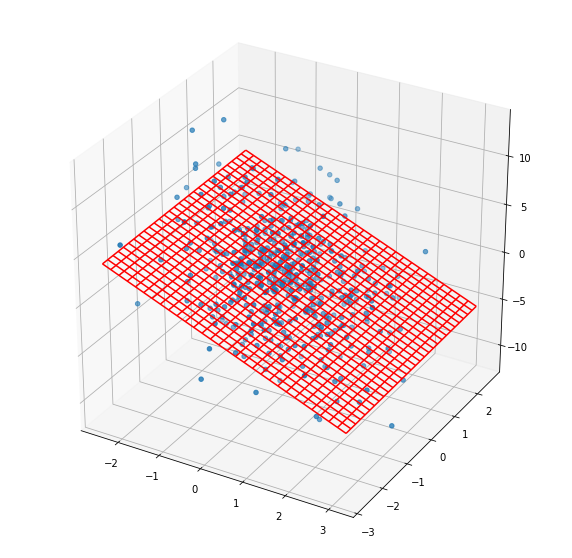

In [256]:
# Visualize the training data set (only meaningful when d=2)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot the conditional mean
maxcoords = np.max(X_train, axis=0)
mincoords = np.min(X_train, axis=0)
x = np.linspace(mincoords[0], maxcoords[0], 30)
y = np.linspace(mincoords[1], maxcoords[1], 30)
X, Y = np.meshgrid(x, y)
Z = X*beta[0] + Y*beta[1]
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, color="red")

# plot the training data
ax.scatter(X_train[:,0], X_train[:,1], np.squeeze(y_train))


In [257]:
# Least-squares fit, empirical risk, and estimate population risk using test data set
beta_OLS = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

risk_emp_OLS = 1/n_train * np.linalg.norm(X_train@beta_OLS - y_train)**2
risk_test_OLS = 1/n_test * np.linalg.norm(X_test@beta_OLS - y_test)**2

print('OLS empirical risk: %f, test risk: %f' % (risk_emp_OLS, risk_test_OLS))

OLS empirical risk: 0.232562, test risk: 0.245818


In [258]:
# Quadratic polynomial fit, empirical risk, and estimate population risk using test data set 

def quad(X):
    return np.apply_along_axis( lambda x: np.append(np.append([1], [x]), np.kron(x,x)), 1, X)

beta_quad_OLS = np.linalg.pinv(quad(X_train).T @ quad(X_train)) @ quad(X_train).T @ y_train

risk_emp_quad_OLS = 1/n_train * np.linalg.norm(quad(X_train)@beta_quad_OLS - y_train)**2
risk_test_quad_OLS = 1/n_test * np.linalg.norm(quad(X_test)@beta_quad_OLS - y_test)**2

print('Quadratic polynomial empirical risk: %f, test risk: %f' % (risk_emp_quad_OLS, risk_test_quad_OLS))

Quadratic polynomial empirical risk: 0.127925, test risk: 0.525352


In [263]:
# Regularize the quadratic fit with l2 penalty and estimate population risk using test data set 
# (since we didn't really try different hyperparameter values, we don't use the validation data set)

lambda2 = 0.0001
beta_quad_OLS_l2_reg = np.linalg.pinv(quad(X_train).T @ quad(X_train) + lambda2 * n_train * np.eye(1+d+d**2)) @ quad(X_train).T @ y_train
risk_emp_quad_OLS_l2_reg = 1/n_train * np.linalg.norm(quad(X_train)@beta_quad_OLS_l2_reg - y_train)**2
risk_test_quad_OLS_l2_reg = 1/n_test * np.linalg.norm(quad(X_test)@beta_quad_OLS_l2_reg - y_test)**2

print('l2-regularized quadratic polynomial empirical risk: %f, test risk: %f' % (risk_emp_quad_OLS_l2_reg, risk_test_quad_OLS_l2_reg))

l2-regularized quadratic polynomial empirical risk: 0.127925, test risk: 0.525590


In [267]:
# Regularize the quadratic fit with l1 penalty 
# (since we didn't really try different hyperparameter values, we don't use the validation data set)
# see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html for the objective that is minimized in the following

lambda1 = 0.0005
clf = Lasso(alpha=lambda1, max_iter=10000)
feats = quad(X_train)
clf.fit(feats, np.squeeze(y_train))

risk_emp_lasso = 1/n_train * np.linalg.norm(clf.predict(feats) - np.squeeze(y_train))**2
risk_test_lasso = 1/n_test * np.linalg.norm(clf.predict(quad(X_test)) - np.squeeze(y_test))**2

print('Lasso quadratic polynomial empirical risk: %f, test risk: %f' % (risk_emp_lasso, risk_test_lasso))

Lasso quadratic polynomial empirical risk: 0.128109, test risk: 0.498777
